In [24]:
#LogP/SA calculator

In [25]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
import random
from rdkit.Chem import rdFreeSASA
#from rdkit.Chem.Draw import IPythonConsole

In [26]:
#monomers for polyamides
amide_dict={'Nylon6': 'CCCCCC(=O)N'
}

#monomers and comonomers for polycarbonates
carbonate_dict={'BPA_Carbonate':  'c1ccc(cc1)C(C)(C)c1ccc(cc1)OC(=O)O'
}

#monomers and comonomers for polyesters
ester_dict={'Butylene_Adip': 'C(=O)CCCCC(=O)OCCCCO',
          'Butylene_Succinate': 'C(=O)CCC(=O)OCCCCO', 
          'Butylene_Terephthalate': 'CCCCOC(=O)c1ccc(cc1)C(=O)O',
          'Ethylene_Terephthalate': 'CCOC(=O)c1ccc(cc1)C(=O)O', 
          '3HBV': 'C(CC)CC(=O)O', 
          '3HB': 'C(C)CC(=O)O',
          'Lactic_acid': 'C(C)C(=O)O',
}

#monomers for polyethers
ether_dict={'Ethylene_oxide': 'CCO',
            'Propylene_oxide': 'CC(C)O'
}

#Vinyl monomers written to depict primary addition of alkene (i.e. substituent is on second carbon of alkene)
vinyl_dict={'Butylacrylate': 'CC(C(=O)OCCCC)',
          'Dimethylacrylamide': 'CC(C(=O)N(C)(C))',
          'Ethylene': 'CC',
          'Hydroxyethylmethacrylate': 'CC(C(=O)OCCO)(C)',
          'Methylacrylate': 'CC(C(=O)OC)C',
          'Methylmethacrylate': 'CC(C(=O)OC)(C)',
          'Propylene': 'CC(C)',
          'Styrene': 'CC(c1ccccc1)',
          'Vinylalcohol': 'CC(O)'
}

#initiator dictionary (i.e. endgroup of polymer chain)
init_dict={'Benzyl': 'c1ccccc1CO', 
           'Butyl': 'CCCC',
           'Hydroxyl': 'O', 
           'Hydrogen': '',
           'Methoxy': 'CO', 
           'Methyl': 'C', 
           'Vinyl': 'C=C'}

In [27]:
#Section 1
#constructing SMILES string for polymers with one type of vinyl monomer unit

#enter number of monomers
n=5

#choose type of initiating group
init=init_dict['Hydrogen']  

#choose monomer composition
comp = 'Nylon6'
N1=amide_dict[comp]

def Polymer1(n):
    n_mer = init+(N1*n)
    return n_mer
Polymer1(n)

'CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N'

In [28]:
#construct SMIlES string for alternating copolymer

##enter number of monomers
#x=5
#y=5

#choose type of initiating group
#initiator=init_dict['Hydroxyl']

#choose monomer composition
#X1=diacid_dict['Adipic_Acid']
#Y1=diol_dict['Butane_Diol']

#def Alt_copolymer(x):
#    alt_copol=(X1+Y1)*x
#    return alt_copol
#Alt_copolymer(x)

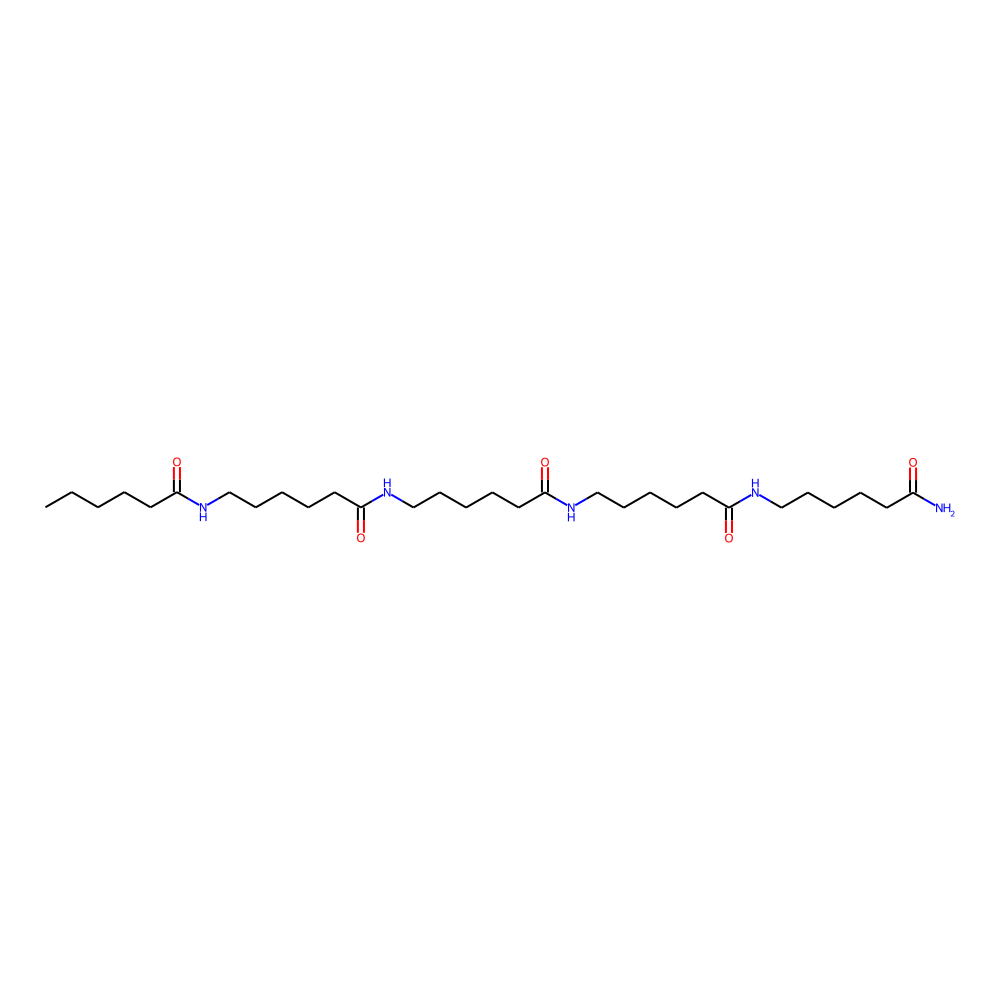

In [29]:
#method to draw molecules

mer_n = [Polymer1(n)]
mol = [Chem.MolFromSmiles(mer_n) for mer_n in mer_n]
Draw.MolsToGridImage(mol, molsPerRow=1, subImgSize=(1000, 1000))

In [7]:
#Section 2
#Workflow involves calculating LogP values and SASA for SMILES strings
#Let's check if H's are added before energy minimization with MMFF (or UFF)

In [8]:
# Get the ID of the best conformer given a molecule with conformers and a set of conformer IDs
# Note that mol_h MUST be pre-populated with the desired conformers
def GetBestConformerID(mol_h, ids, returnMinusOne=False):
    best = []
    for id in ids:
        prop = AllChem.MMFFGetMoleculeProperties(mol_h)
        ff = AllChem.MMFFGetMoleculeForceField(mol_h, prop, confId=id)
        ff.Minimize()
        en = float(ff.CalcEnergy())
        econf = (en, id)
        best.append(econf)
    best.sort()
    print("Found "+str(len(best))+" conformations.")
    if len(best) == 0 and returnMinusOne is True:
        return -1
    elif len(best) == 0:
        raise Exception("Error: No valid conformations found for the molecule. Try increasing the number of conformations.")
    # The best conformer is the first tuple and the ID of that conformer is the second value in the tuple
    best_id = int(best[0][1])
    # Return the best ID
    return best_id

# Utility method to save a conformer to a file
# Accepts a molecule, conformer ID, and filename
# Note that this function has a HARDCODED PREFIX FOLDER that it saves files inside of.
def SaveConformationToFile(molecule, confId=-1, filename="scratch"):
    # Hardcoded prefix where the files are saved - change if necessary
    prefix = "molecules/"
    if confId == -1:
        raise Exception("You must provide a conformation ID to use this function.")
    # Get the conformation with the given ID
    best_conf = Chem.MolToMolBlock(molecule,confId=confId)
    # Open the file, write, then close the file.
    f = open(prefix + filename, 'w+')
    # MAKE SURE this doesn't just append to the file over and over again, which would be bad
    f.write(best_conf)
    f.close()
    print("Successfully wrote conformation to file.")
    return prefix + filename

# Given a SMILES string and other parameters, this function generates the required number of conformers and gets the LogP 
# and SASA for the best one
# Calculates logP for the OVERALL MOLECULE since I couldn't work out how to do it for a conformer
# DANGER - the output of this function is NOT 100% consistent; if you get your LogP and SASA from two different runs
# you WILL run into problems. Get ALL your values at the SAME TIME.
def GetLogPAndSASAForBestConformer(smiles, numThreads=1, numConfs=1000, randomSeed=1, filename=None, useRandomCoords=True,
                                  returnMinusOne=False):
    # File prefix - change if necessary
    prefix = "molecules/",
    # First process the SMILES string
    mol = Chem.MolFromSmiles(smiles)
    mol_h = Chem.AddHs(mol)
    # Now generate the conformations
    ids = AllChem.EmbedMultipleConfs(mol_h, numConfs=numConfs, randomSeed=randomSeed, useExpTorsionAnglePrefs=True,
                                     numThreads=numThreads)
    # Find the best one
    try:
        best_conf_id = GetBestConformerID(mol_h, ids)
    except Exception as e:
        if returnMinusOne is True:
            return 0, 1
        else:
            raise e
    print("Best conformer ID is "+str(best_conf_id)+".")
    if filename is not None and returnMinusOne is False:
        # If filename given, save conformation to that file
        SaveConformationToFile(mol_h, confId=best_conf_id, filename=filename)
    elif best_conf_id == -1 and returnMinusOne is True:
        return 0, 1
    # Now calculate LogP and SASA
    # Calculate SASA based on the best conformer
    # classifyAtoms CRASHED when I tried it with , confIdx=best_conf_id
    # but someone needs to go back and make sure it's actually OK to use it without
    # and that that won't cause problems!
    radii = rdFreeSASA.classifyAtoms(mol_h)
    sasa = rdFreeSASA.CalcSASA(mol_h, radii, confIdx=best_conf_id)
    # LogP does NOT have an option to feed in a conformer so just calculate it for the overall molecule
    logP = Descriptors.MolLogP(mol_h)
    # Now return LogP and SASA
    return logP, sasa

In [9]:
file_name=comp+"_"+str(n)+"mer"+".mol" #name of mol file
print(file_name)

Nylon6_5mer.mol


In [10]:
#save 3D molecule as .mol file
mol = Chem.MolFromSmiles(Polymer1(n)) #convert SMILES string to molecule
mol_h = Chem.AddHs(mol) #add hydrogens
AllChem.EmbedMolecule(mol_h,randomSeed=0xf00d)   # optional random seed for reproducibility
AllChem.MMFFOptimizeMolecule(mol_h) #performed MMFF
#print(Chem.MolToMolBlock(mol_h))
#print(Chem.MolToMolBlock(mol_h),file=open("molecules/"+file_name,'w+')) #open and write to the file

#GetBestConformationAndSave(Polymer1(n),numConfs=10,numThreads=5)

1

In [11]:
#Calculate the molecular volume
Chem.AllChem.ComputeMolVolume(mol_h, confId=- 1, gridSpacing=0.2, boxMargin=2.0)

589.0000000000001

In [12]:
ids = AllChem.EmbedMultipleConfs(mol_h, numConfs=10, randomSeed=1, useExpTorsionAnglePrefs=True, numThreads=6)
best=[]
for id in ids:
	prop = AllChem.MMFFGetMoleculeProperties(mol_h)
	ff = AllChem.MMFFGetMoleculeForceField(mol_h, prop, confId=id)
	ff.Minimize()
	en = float(ff.CalcEnergy())
	econf = (en, id)
	best.append(econf)
best.sort()
print(best[0])
print(best)


(-120.92305890550224, 3)
[(-120.92305890550224, 3), (-118.79649877716557, 2), (-116.91066596533204, 9), (-115.4353548826765, 5), (-114.96969588184311, 1), (-114.25346051515321, 7), (-113.399925857061, 8), (-112.10663287859047, 4), (-111.12016956366136, 6), (-104.97995005351208, 0)]


In [13]:
#Helper functions for SASA

def smiles_to_rdkit(inputSMILES):
    # create fake building block so we can use STK to convert to an RDKit molecule
	mol = Chem.MolFromSmiles(inputSMILES)
	mol_h = Chem.AddHs(mol) #add hydrogens
	AllChem.EmbedMolecule(mol_h,randomSeed=0xf00d,useRandomCoords=True)   # optional random seed for reproducibility
	AllChem.MMFFOptimizeMolecule(mol_h, maxIters=10000) #performed MMFF
	return mol_h

# convert SMILES string to RDKit molecule
#def smiles_to_rdkit(inputSMILES):
#    # create fake building block so we can use STK to convert to an RDKit molecule
#    bb_from_smiles = stk.BuildingBlock(inputSMILES)
#    rdkit_mol = bb_from_smiles.to_rdkit_mol()
#    Chem.rdmolops.SanitizeMol(rdkit_mol3)
    # add hydrogens
#    rdkit_mol_with_H = Chem.rdmolops.AddHs(rdkit_mol)
    # or not...
#    rdkit_mol_with_H = rdkit_mol
    # not sure what order addHs/sanitizing needs to run in so we will just be wasteful
#    Chem.rdmolops.SanitizeMol(rdkit_mol_with_H)
    # optimize with MMFF (or UFF)
#   Chem.AllChem.MMFFOptimizeMolecule(rdkit_mol_with_H, maxIters=20000) #default settings for maxIters is 200
#    return rdkit_mol_with_H

# calculate SASA given SMILES string
def sasa_from_smiles(inputSMILES):
    mol_h = smiles_to_rdkit(inputSMILES)
    radii = rdFreeSASA.classifyAtoms(mol_h)
    sasa = rdFreeSASA.CalcSASA(mol_h, radii)
    return sasa

In [14]:
#LogP values for n-mer

z=Chem.MolFromSmiles(Polymer1(n))
print('LogP with hydrogens is: '+ str(Descriptors.MolLogP(z, includeHs=True)))

z_no_Hs=Chem.MolFromSmiles(Polymer1(n))
print('LogP without hydrogens is: '+ str(Descriptors.MolLogP(z_no_Hs, includeHs=False)))

LogP with hydrogens is: 3.7584000000000044
LogP without hydrogens is: -3.7998000000000003


In [15]:
#TESTING
testv = 1
while testv <= 2:
    print("Beginning test for "+str(testv))
    print(Polymer1(testv))
    try:
        testf = smiles_to_rdkit(Polymer1(testv))
        print("Successfully tested "+str(testv))
    except:
        print("Testing for "+str(testv)+" failed")
    testv += 1

y=2
while y <= n:
    print ("LogP for n =", y, ":", Descriptors.MolLogP(Chem.MolFromSmiles(Polymer1(y))))
    print("SASA for n =", y, ":", sasa_from_smiles(Polymer1(y)))
    print("LogP/SA for n =", y, ":", (Descriptors.MolLogP(Chem.MolFromSmiles(Polymer1(y)))/(sasa_from_smiles(Polymer1(y)))))
    y+=1

Beginning test for 1
CCCCCC(=O)N
Successfully tested 1
Beginning test for 2
CCCCCC(=O)NCCCCCC(=O)N


Successfully tested 2
LogP for n = 2 : 1.7286


SASA for n = 2 : 376.17421439446684


LogP/SA for n = 2 : 0.004595211297995405
LogP for n = 3 : 2.4052000000000007


SASA for n = 3 : 531.016883696174


LogP/SA for n = 3 : 0.0045294228372899665
LogP for n = 4 : 3.081800000000002


SASA for n = 4 : 713.606446135372


LogP/SA for n = 4 : 0.0043186269079965416
LogP for n = 5 : 3.7584000000000044


SASA for n = 5 : 862.7327553675683


LogP/SA for n = 5 : 0.004356389596450101


In [16]:
#create an array of LogP values
#and SASA values
LogP_Polymer1 = []#LogP
SASA_Polymer1 = []#surface area
Old_SASA_Polymer1 = []
DP_Polymer1 =[]#length
for y in range(1,11,1):
    filename = comp+"_"+str(y)+"mer"+".mol" #name of mol file
    print(Polymer1(y))
    best_conf_values = GetLogPAndSASAForBestConformer(Polymer1(y), numConfs=100, numThreads=5, randomSeed=1, filename=filename)
    LogP_Polymer1.append(best_conf_values[0])
    SASA_Polymer1.append(best_conf_values[1])
    Old_SASA_Polymer1.append(sasa_from_smiles(Polymer1(y)))
    DP_Polymer1.append(y)
    y +=1
print("length of oligomers:", DP_Polymer1)
print("LogP values:", LogP_Polymer1)
print("Surface areas:", SASA_Polymer1)
print("Old surface areas:", Old_SASA_Polymer1)

CCCCCC(=O)N


Found 100 conformations.
Best conformer ID is 76.
Successfully wrote conformation to file.
CCCCCC(=O)NCCCCCC(=O)N


Found 100 conformations.
Best conformer ID is 73.
Successfully wrote conformation to file.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 100 conformations.
Best conformer ID is 13.
Successfully wrote conformation to file.


CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 100 conformations.
Best conformer ID is 58.
Successfully wrote conformation to file.


CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 100 conformations.
Best conformer ID is 42.
Successfully wrote conformation to file.


CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 100 conformations.
Best conformer ID is 37.
Successfully wrote conformation to file.


CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 98 conformations.
Best conformer ID is 21.
Successfully wrote conformation to file.


CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 84 conformations.
Best conformer ID is 7.
Successfully wrote conformation to file.


CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 41 conformations.
Best conformer ID is 7.
Successfully wrote conformation to file.


CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 21 conformations.
Best conformer ID is 16.
Successfully wrote conformation to file.


length of oligomers: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
LogP values: [1.052, 1.7286, 2.4052000000000007, 3.081800000000002, 3.7584000000000044, 4.435000000000006, 5.111600000000008, 5.7882000000000104, 6.464800000000013, 7.141400000000015]
Surface areas: [206.6925057280428, 369.8199742976483, 532.6578667176307, 721.107614238558, 882.5633661695402, 1046.5505321615533, 1232.626123377676, 1405.160455768095, 1576.6305906160728, 1757.4180869383592]
Old surface areas: [203.77204261448406, 376.17421439446684, 531.016883696174, 713.606446135372, 862.7327553675683, 1021.9818714991899, 1166.4549241955954, 1349.4172575775037, 1523.3464339040288, 1690.3164223699682]


In [17]:
import numpy as np
LogP_SASA = np.divide(LogP_Polymer1,SASA_Polymer1)
print("LogP/SA:", LogP_SASA.round(4))

LogP/SA: [0.0051 0.0047 0.0045 0.0043 0.0043 0.0042 0.0041 0.0041 0.0041 0.0041]


In [18]:


# Additional values for comparison purposes
# Feel free to delete this for performance reasons when you're done with the comparison table below
#create an array of LogP values
#and SASA values
#LogP_Polymer1 = []#LogP
#SASA_Polymer_2DArray = []#surface area
#DP_Polymer1 =[]#length
#for y in range(2,13,2):
#    print(Polymer1(y))
#    best_conf_value_100 = GetLogPAndSASAForBestConformer(Polymer1(y), numConfs=100, numThreads=5, randomSeed=1)
#    LogP_Polymer1.append(best_conf_value_100[0])
#    SASA_Polymer1_100.append(best_conf_value_100[1])
#    SASA_Polymer1_200.app
#    DP_Polymer1.append(y)
#    y +=1
#print("length of oligomers:", DP_Polymer1)
#print("LogP values:", LogP_Polymer1)
#print("Surface areas:", SASA_Polymer1)
#print("Old surface areas:", Old_SASA_Polymer1)

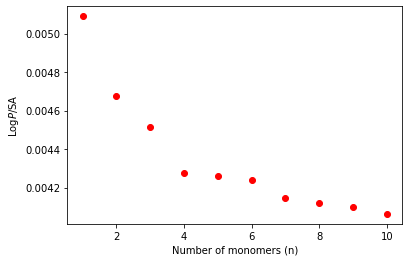

In [19]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.scatter(DP_Polymer1,(np.divide(LogP_Polymer1,SASA_Polymer1)), color = 'red')
plt.ylabel('Log$P$/SA')
plt.xlabel('Number of monomers (n)')
plt.show()

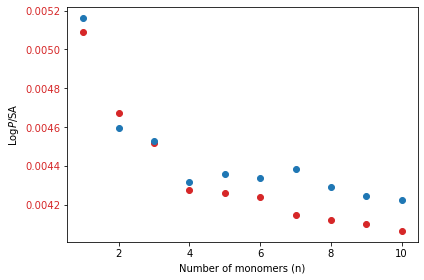

In [20]:
# Graph old and new values on the same axes
# Old SASA = red, new SASA = blue
mpl_color='tab:red'
fig, mpl_logp = plt.subplots()
mpl_logp.set_xlabel('Number of monomers (n)')
mpl_logp.set_ylabel('Log$P$/SA')
mpl_logp.scatter(DP_Polymer1,np.divide(LogP_Polymer1,SASA_Polymer1),color=mpl_color)
mpl_logp.scatter(DP_Polymer1,np.divide(LogP_Polymer1,Old_SASA_Polymer1),color='tab:blue')
mpl_logp.tick_params(axis='y',labelcolor=mpl_color)

fig.tight_layout()
plt.show()

In [21]:
# Show the results for different numbers of conformers
# <insert joke about rainbow tables here>
# Red = 0, orange = 10, yellow = 25, green = 50, blue = 100, purple = 200

test_conformers = [10, 25, 50, 100, 150, 200]

testdata = [[], [], [], [], [], []]



LogP_Polymer1 = []#LogP
SASA_Polymer1 = []#surface area
Old_SASA_Polymer1 = []
DP_Polymer1 =[0, 0, 0, 0, 0, 0]#length
for i in range(len(test_conformers)):
    Old_SASA_Polymer1.append(sasa_from_smiles(Polymer1(y)))
    testdata[i] = [0, 0, 0, 0, 0, 0]
    j = 0
    for y in range(2,13,2):
        print(Polymer1(y))
        holding = GetLogPAndSASAForBestConformer(Polymer1(y), numConfs=test_conformers[i], numThreads=5, randomSeed=1,
                                                returnMinusOne=True)
        testdata[i][j] = (holding[0]/holding[1])
        j += 1
        if DP_Polymer1[i] == 0:
            DP_Polymer1.append(y)
    print(testdata[i])
print(testdata)

DP_Polymer1 = [2, 4, 6, 8, 10, 12]




CCCCCC(=O)NCCCCCC(=O)N


Found 10 conformations.
Best conformer ID is 1.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 10 conformations.
Best conformer ID is 4.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 10 conformations.
Best conformer ID is 6.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 8 conformations.
Best conformer ID is 7.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 2 conformations.
Best conformer ID is 0.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 0 conformations.
[0.004720196476679136, 0.004246350434826342, 0.004227962045300323, 0.004119244870747546, 0.00409074460181928, 0.0]


CCCCCC(=O)NCCCCCC(=O)N


Found 25 conformations.
Best conformer ID is 1.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 25 conformations.
Best conformer ID is 20.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 25 conformations.
Best conformer ID is 6.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 20 conformations.
Best conformer ID is 7.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 3 conformations.
Best conformer ID is 2.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 0 conformations.
[0.004720196476679136, 0.004267052381379993, 0.004227962045300323, 0.004119244870747546, 0.004053838884898611, 0.0]


CCCCCC(=O)NCCCCCC(=O)N


Found 50 conformations.
Best conformer ID is 1.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 50 conformations.
Best conformer ID is 27.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 50 conformations.
Best conformer ID is 37.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 43 conformations.
Best conformer ID is 7.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 8 conformations.
Best conformer ID is 2.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 1 conformations.
Best conformer ID is 0.
[0.004720196476679136, 0.004324074229735661, 0.0042377313504775764, 0.004119244870747546, 0.004053838884898611, 0.004064006290956566]


CCCCCC(=O)NCCCCCC(=O)N


Found 100 conformations.
Best conformer ID is 73.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 100 conformations.
Best conformer ID is 58.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 100 conformations.
Best conformer ID is 37.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 84 conformations.
Best conformer ID is 7.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 21 conformations.
Best conformer ID is 16.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 1 conformations.
Best conformer ID is 0.
[0.004674166135247044, 0.004273703312998822, 0.0042377313504775764, 0.004119244870747546, 0.004063574884699874, 0.004064006290956566]


CCCCCC(=O)NCCCCCC(=O)N


Found 150 conformations.
Best conformer ID is 73.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 150 conformations.
Best conformer ID is 104.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 150 conformations.
Best conformer ID is 37.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 127 conformations.
Best conformer ID is 7.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 28 conformations.
Best conformer ID is 16.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 3 conformations.
Best conformer ID is 0.
[0.004674166135247044, 0.004396589427011989, 0.0042377313504775764, 0.004119244870747546, 0.004063574884699874, 0.004064006290956566]


CCCCCC(=O)NCCCCCC(=O)N


Found 200 conformations.
Best conformer ID is 73.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 200 conformations.
Best conformer ID is 104.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 200 conformations.
Best conformer ID is 37.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 162 conformations.
Best conformer ID is 7.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 35 conformations.
Best conformer ID is 16.
CCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)NCCCCCC(=O)N


Found 4 conformations.
Best conformer ID is 0.
[0.004674166135247044, 0.004396589427011989, 0.0042377313504775764, 0.004119244870747546, 0.004063574884699874, 0.004064006290956566]
[[0.004720196476679136, 0.004246350434826342, 0.004227962045300323, 0.004119244870747546, 0.00409074460181928, 0.0], [0.004720196476679136, 0.004267052381379993, 0.004227962045300323, 0.004119244870747546, 0.004053838884898611, 0.0], [0.004720196476679136, 0.004324074229735661, 0.0042377313504775764, 0.004119244870747546, 0.004053838884898611, 0.004064006290956566], [0.004674166135247044, 0.004273703312998822, 0.0042377313504775764, 0.004119244870747546, 0.004063574884699874, 0.004064006290956566], [0.004674166135247044, 0.004396589427011989, 0.0042377313504775764, 0.004119244870747546, 0.004063574884699874, 0.004064006290956566], [0.004674166135247044, 0.004396589427011989, 0.0042377313504775764, 0.004119244870747546, 0.004063574884699874, 0.004064006290956566]]


In [22]:
# now actually graph the data
createComparison = False
if createComparison is True:
    DP_Polymer1 = [2, 4, 6, 8, 10, 12]
    Old_SASA_Polymer1 = []
    for i in range(len(DP_Polymer1)):
        mol = Chem.MolFromSmiles(Polymer1(int(DP_Polymer1[i])))
        mol_with_H = Chem.AddHs(mol)
        Old_SASA_Polymer1.append(Descriptors.MolLogP(mol_with_H)/sasa_from_smiles(Polymer1(int(DP_Polymer1[i]))))

    fig, mpl_logp = plt.subplots()
    mpl_logp.set_xlabel('DP')
    mpl_logp.set_ylabel('LogP/SA')
    mpl_logp.scatter(DP_Polymer1,Old_SASA_Polymer1,color='tab:red')
    mpl_logp.scatter(DP_Polymer1,testdata[0],color='tab:orange')
    mpl_logp.scatter(DP_Polymer1,testdata[1],color='tab:olive')
    mpl_logp.scatter(DP_Polymer1,testdata[2],color='tab:green')
    mpl_logp.scatter(DP_Polymer1,testdata[3],color='tab:cyan')
    mpl_logp.scatter(DP_Polymer1,testdata[4],color='tab:blue')
    mpl_logp.scatter(DP_Polymer1,testdata[5],color='tab:purple')
    mpl_logp.tick_params(axis='y')

    fig.tight_layout()
    plt.show()

ValueError: x and y must be the same size

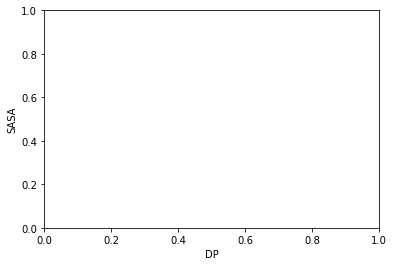

In [23]:
# Graph just SASA for comparison/curiosity purposes
# Old SASA = red, new SASA = blue
fig, mpl_logp = plt.subplots()
mpl_logp.set_xlabel('DP')
mpl_logp.set_ylabel('SASA')
mpl_logp.scatter(DP_Polymer1,SASA_Polymer1,color='tab:red')
mpl_logp.scatter(DP_Polymer1,Old_SASA_Polymer1,color='tab:blue')
mpl_logp.tick_params(axis='y',labelcolor=mpl_color)

fig.tight_layout()
plt.show()

In [0]:
# Try to graph both LogP and SASA on the same axes
mpl_color='tab:red'
fig, mpl_logp = plt.subplots()
mpl_logp.set_xlabel('DP')
mpl_logp.set_ylabel('LogP')
mpl_logp.scatter(DP_Polymer1,LogP_Polymer1,color=mpl_color)
mpl_logp.tick_params(axis='y',labelcolor=mpl_color)

mpl_sasa = mpl_logp.twinx()

mpl_color='tab:blue'
mpl_sasa.set_ylabel('SASA')
mpl_sasa.scatter(DP_Polymer1,SASA_Polymer1,color=mpl_color)
mpl_sasa.tick_params(axis='y',labelcolor=mpl_color)

fig.tight_layout()
plt.show()

In [0]:
#Section 3
#Workflow involves visually checking to see how well energy minimization worked with MMFF
#Can we display energy of conformations?